In [1]:
import pandas as pd
import numpy as np
from model import *
import extractor
class Extractor(extractor.AudioDataExtractionPipeline):
    pass

In [2]:
import pandas as pd
df = pd.read_csv("dataset/Data/features_30_sec.csv")
df

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,rock.00095.wav,661794,0.352063,0.080487,0.079486,0.000345,2008.149458,282174.689224,2106.541053,88609.749506,...,45.050526,-13.289984,41.754955,2.484145,36.778877,-6.713265,54.866825,-1.193787,49.950665,rock
996,rock.00096.wav,661794,0.398687,0.075086,0.076458,0.000588,2006.843354,182114.709510,2068.942009,82426.016726,...,33.851742,-10.848309,39.395096,1.881229,32.010040,-7.461491,39.196327,-2.795338,31.773624,rock
997,rock.00097.wav,661794,0.432142,0.075268,0.081651,0.000322,2077.526598,231657.968040,1927.293153,74717.124394,...,33.597008,-12.845291,36.367264,3.440978,36.001110,-12.588070,42.502201,-2.106337,29.865515,rock
998,rock.00098.wav,661794,0.362485,0.091506,0.083860,0.001211,1398.699344,240318.731073,1818.450280,109090.207161,...,46.324894,-4.416050,43.583942,1.556207,34.331261,-5.041897,47.227180,-3.590644,41.299088,rock


In [3]:
from sklearn.model_selection import train_test_split

# Define features and target
X = df.drop(columns=['label'])  # Features: e.g., 'track' and 'statistics'
y = df['label']  # Target: 'label'

# Split the dataset while preserving class proportions
X_train, X_eval, y_train, y_eval = train_test_split(
    X, y, 
    test_size=0.3,  # 30% for testing
    stratify=y,     # Preserve class proportions
    random_state=42 # For reproducibility
)

In [4]:
# Drop corrupted sample 
idx = X_train.index[X_train["filename"] == "jazz.00054.wav"]
X_train = X_train.drop(index=idx)
y_train = y_train.drop(index=idx)

In [5]:
model, acc = train_and_evaluate_catboost(
    X_eval.index.to_numpy(), 
    X_train.drop(columns=["filename", "length"]).to_numpy(), 
    X_eval.drop(columns=["filename", "length"]).to_numpy(), 
    y_train.to_numpy(), 
    y_eval.to_numpy()
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3648069	test: 0.3433333	best: 0.3433333 (0)	total: 61.9ms	remaining: 30.9s
50:	learn: 0.7367668	test: 0.6566667	best: 0.6700000 (47)	total: 199ms	remaining: 1.75s
100:	learn: 0.8211731	test: 0.7200000	best: 0.7233333 (98)	total: 339ms	remaining: 1.34s
150:	learn: 0.8726753	test: 0.7300000	best: 0.7400000 (122)	total: 475ms	remaining: 1.1s
200:	learn: 0.9070100	test: 0.7366667	best: 0.7466667 (182)	total: 612ms	remaining: 911ms
250:	learn: 0.9313305	test: 0.7366667	best: 0.7533333 (218)	total: 752ms	remaining: 746ms
300:	learn: 0.9484979	test: 0.7533333	best: 0.7533333 (218)	total: 896ms	remaining: 592ms
350:	learn: 0.9670959	test: 0.7466667	best: 0.7600000 (318)	total: 1.05s	remaining: 444ms
400:	learn: 0.9728183	test: 0.7466667	best: 0.7600000 (318)	total: 1.2s	remaining: 296ms
450:	learn: 0.9756795	test: 0.7400000	best: 0.7600000 (318)	total: 1.37s	remaining: 149ms
499:	learn: 0.9842632	test: 0.7466667	best: 0.7600000 (318)	total: 1.51s	remaining: 0us

bestTest = 0.76
bes

In [6]:
import soundfile as sf
import librosa
import numpy as np
from resampy import resample

In [7]:
E_train = Extractor(
    idx=[np.array([row[0]]) for row in X_train.iterrows()],
    x=[row[1].to_numpy() for row in X_train.iterrows()],
    y=[np.array([row]) for row in y_train],
    train=True
)
E_eval = Extractor(
    idx=[np.array([row[0]]) for row in X_eval.iterrows()],
    x=[row[1].to_numpy() for row in X_eval.iterrows()],
    y=[np.array([row]) for row in y_eval],
    train=False
)

def load_audio(x) -> [np.ndarray]:
    file_path = f"dataset/Data/genres_original/{x[0].split('.')[0]}/{x[0]}"
    y, sr = sf.read(file_path)
    if len(y.shape) == 2:  # Convert stereo to mono
        y = np.mean(y, dim=0)
    if sr != 22050:
        y = resample(y, sr, 22050)
    return y
Extractor.register_extractor('audio', load_audio)
E_train.full_extract()
E_eval.full_extract()

audio:   0%|          | 0/699 [00:00<?, ?it/s]

audio:   0%|          | 0/300 [00:00<?, ?it/s]

In [8]:
Extractor.register_extractor('stats', lambda x: x[2:])
Extractor.register_extractor('rms', lambda audio: np.array([np.sqrt(np.mean(audio**2))]))
E_train.soft_extract()
E_eval.soft_extract()

stats:   0%|          | 0/699 [00:00<?, ?it/s]

rms:   0%|          | 0/699 [00:00<?, ?it/s]

stats:   0%|          | 0/300 [00:00<?, ?it/s]

rms:   0%|          | 0/300 [00:00<?, ?it/s]

In [9]:
import librosa
import soundfile as sf
from resampy import resample
from tqdm.notebook import tqdm

sr = 22050
hop_length = 512
n_mfcc = 20
n_mels = 128
n_bins = 84
bins_per_octave = 12
fmin = librosa.note_to_hz("C1")


def mel(audio):
    # Calculate MelSpectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)  # Convert to decibel scale
    return mel_spectrogram

Extractor.register_extractor('mel', mel)
Extractor.register_extractor('cqt', lambda audio: np.abs(librosa.cqt(audio, sr=sr, hop_length=hop_length, fmin=fmin, bins_per_octave=bins_per_octave, n_bins=n_bins)))
Extractor.register_extractor('stft', lambda audio: librosa.stft(audio, hop_length=hop_length))
Extractor.register_extractor('mfcc', lambda audio: librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc))


In [10]:
E_train.soft_extract()
E_eval.soft_extract()

mel:   0%|          | 0/699 [00:00<?, ?it/s]

cqt:   0%|          | 0/699 [00:00<?, ?it/s]

stft:   0%|          | 0/699 [00:00<?, ?it/s]

mfcc:   0%|          | 0/699 [00:00<?, ?it/s]

mel:   0%|          | 0/300 [00:00<?, ?it/s]

cqt:   0%|          | 0/300 [00:00<?, ?it/s]

stft:   0%|          | 0/300 [00:00<?, ?it/s]

mfcc:   0%|          | 0/300 [00:00<?, ?it/s]

In [11]:
import matplotlib.pyplot as plt

In [12]:
hop_length=512
Extractor.register_extractor('bpm_beat', lambda audio: librosa.beat.beat_track(y=audio, sr=sr, hop_length=hop_length))
Extractor.register_extractor('bpm', lambda bpm_beat: bpm_beat[0])
Extractor.register_extractor('beat', lambda bpm_beat: bpm_beat[1])

In [13]:
E_train.soft_extract()
E_eval.soft_extract()

bpm_beat:   0%|          | 0/699 [00:00<?, ?it/s]

bpm:   0%|          | 0/699 [00:00<?, ?it/s]

beat:   0%|          | 0/699 [00:00<?, ?it/s]

bpm_beat:   0%|          | 0/300 [00:00<?, ?it/s]

bpm:   0%|          | 0/300 [00:00<?, ?it/s]

beat:   0%|          | 0/300 [00:00<?, ?it/s]

In [14]:
Extractor.register_extractor('cqt_hpss', lambda cqt: librosa.decompose.hpss(cqt))
Extractor.register_extractor('harmonic', lambda cqt_hpss: cqt_hpss[0])
Extractor.register_extractor('percussive', lambda cqt_hpss: cqt_hpss[1])

In [15]:
E_train.soft_extract()
E_eval.soft_extract()

cqt_hpss:   0%|          | 0/699 [00:00<?, ?it/s]

harmonic:   0%|          | 0/699 [00:00<?, ?it/s]

percussive:   0%|          | 0/699 [00:00<?, ?it/s]

cqt_hpss:   0%|          | 0/300 [00:00<?, ?it/s]

harmonic:   0%|          | 0/300 [00:00<?, ?it/s]

percussive:   0%|          | 0/300 [00:00<?, ?it/s]

(0.0, 30.0)

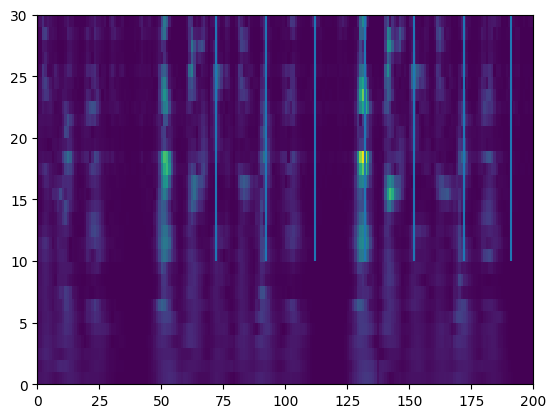

In [16]:
plt.pcolor(E_train.features['percussive'][0])
plt.vlines(E_train.features['beat'][0], 10, 30)
plt.xlim(0, 200)
plt.ylim(0, 30)

In [17]:
Extractor.register_extractor('cqt_per_freq_mean', lambda cqt: cqt.mean(axis=1))
Extractor.register_extractor('cqt_per_freq_var', lambda cqt: cqt.var(axis=1))
Extractor.register_extractor('harmonic_per_freq_mean', lambda harmonic: harmonic.mean(axis=1))
Extractor.register_extractor('harmonic_per_freq_var', lambda harmonic: harmonic.var(axis=1))
Extractor.register_extractor('percussive_per_freq_mean', lambda percussive: percussive.mean(axis=1))
Extractor.register_extractor('percussive_per_freq_var', lambda percussive: percussive.var(axis=1))

In [18]:
E_train.soft_extract()
E_eval.soft_extract()

cqt_per_freq_mean:   0%|          | 0/699 [00:00<?, ?it/s]

cqt_per_freq_var:   0%|          | 0/699 [00:00<?, ?it/s]

harmonic_per_freq_mean:   0%|          | 0/699 [00:00<?, ?it/s]

harmonic_per_freq_var:   0%|          | 0/699 [00:00<?, ?it/s]

percussive_per_freq_mean:   0%|          | 0/699 [00:00<?, ?it/s]

percussive_per_freq_var:   0%|          | 0/699 [00:00<?, ?it/s]

cqt_per_freq_mean:   0%|          | 0/300 [00:00<?, ?it/s]

cqt_per_freq_var:   0%|          | 0/300 [00:00<?, ?it/s]

harmonic_per_freq_mean:   0%|          | 0/300 [00:00<?, ?it/s]

harmonic_per_freq_var:   0%|          | 0/300 [00:00<?, ?it/s]

percussive_per_freq_mean:   0%|          | 0/300 [00:00<?, ?it/s]

percussive_per_freq_var:   0%|          | 0/300 [00:00<?, ?it/s]

In [19]:
features = ['cqt_per_freq_mean', 'cqt_per_freq_var', 'harmonic_per_freq_mean', 'harmonic_per_freq_var', 'percussive_per_freq_mean', 'percussive_per_freq_var']

model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['y'])[:,0], 
    y_eval=E_eval.get_features(['y'])[:,0],
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2689557	test: 0.3000000	best: 0.3000000 (0)	total: 62.6ms	remaining: 31.2s
50:	learn: 0.6909871	test: 0.5766667	best: 0.5800000 (46)	total: 1.44s	remaining: 12.7s
100:	learn: 0.7825465	test: 0.6166667	best: 0.6200000 (98)	total: 2.69s	remaining: 10.6s
150:	learn: 0.8340486	test: 0.6266667	best: 0.6266667 (134)	total: 4.08s	remaining: 9.44s
200:	learn: 0.8726753	test: 0.6500000	best: 0.6566667 (184)	total: 5.42s	remaining: 8.06s
250:	learn: 0.9098712	test: 0.6600000	best: 0.6600000 (233)	total: 6.77s	remaining: 6.72s
300:	learn: 0.9256080	test: 0.6600000	best: 0.6700000 (289)	total: 8.13s	remaining: 5.37s
350:	learn: 0.9341917	test: 0.6766667	best: 0.6833333 (338)	total: 9.34s	remaining: 3.96s
400:	learn: 0.9470672	test: 0.6833333	best: 0.6900000 (389)	total: 10.7s	remaining: 2.64s
450:	learn: 0.9670959	test: 0.6933333	best: 0.6933333 (436)	total: 12.3s	remaining: 1.33s
499:	learn: 0.9742489	test: 0.6933333	best: 0.6933333 (436)	total: 14.4s	remaining: 0us

bestTest = 0.6933

In [20]:
Extractor.register_extractor('mfcc_quef_mean', lambda mfcc: mfcc.mean(axis=1))
Extractor.register_extractor('mfcc_quef_var', lambda mfcc: mfcc.var(axis=1))

# Usually STFT is used for spectral centroid, but I will use CQT, it may turn out to be even more precise.
cqt_frequencies = librosa.cqt_frequencies(n_bins=n_bins, fmin=fmin, bins_per_octave=bins_per_octave)
# Extractor.register_extractor('cqt_spectral_centroid', 
#                              lambda cqt: np.sum(cqt_frequencies.reshape(-1, 1) * librosa.util.normalize(cqt, norm=1, axis=0), axis=0))
Extractor.register_extractor('cqt_spectral_centroid', 
                             lambda audio: librosa.feature.spectral_centroid(y=audio, sr=sr))

Extractor.register_extractor('cqt_spectral_centroid_mean', lambda cqt_spectral_centroid: cqt_spectral_centroid.mean())
Extractor.register_extractor('cqt_spectral_centroid_var', lambda cqt_spectral_centroid: cqt_spectral_centroid.var())

cqt_frequencies = librosa.cqt_frequencies(n_bins=n_bins, fmin=fmin, bins_per_octave=bins_per_octave)
chroma_map = librosa.filters.cq_to_chroma(cqt_frequencies.shape[0], bins_per_octave=bins_per_octave, n_chroma=bins_per_octave, fmin=fmin)
Extractor.register_extractor('cqt_chroma', 
                             lambda cqt: np.dot(chroma_map, cqt))
Extractor.register_extractor('cqt_chroma_freq_mean', lambda cqt_chroma: cqt_chroma.mean(axis=1))
Extractor.register_extractor('cqt_chroma_freq_var', lambda cqt_chroma: cqt_chroma.var(axis=1))
Extractor.register_extractor('cqt_chroma_mean', lambda cqt_chroma: cqt_chroma.mean())
Extractor.register_extractor('cqt_chroma_var', lambda cqt_chroma: cqt_chroma.var())

Extractor.register_extractor('harmonic_chroma', 
                             lambda harmonic: np.dot(chroma_map, harmonic))
Extractor.register_extractor('harmonic_chroma_freq_mean', lambda harmonic_chroma: harmonic_chroma.mean(axis=1))
Extractor.register_extractor('harmonic_chroma_freq_var', lambda harmonic_chroma: harmonic_chroma.var(axis=1))
Extractor.register_extractor('harmonic_chroma_mean', lambda harmonic_chroma: harmonic_chroma.mean())
Extractor.register_extractor('harmonic_chroma_var', lambda harmonic_chroma: harmonic_chroma.var())

roll_percent = 0.85
# Extractor.register_extractor('cqt_rolloff', 
#                              lambda cqt: librosa.feature.spectral.spectral_rolloff(S=cqt, freq=cqt_frequencies, roll_percent=roll_percent))
Extractor.register_extractor('cqt_rolloff', 
                             lambda audio: librosa.feature.spectral.spectral_rolloff(y=audio, sr=sr, roll_percent=roll_percent))

Extractor.register_extractor('cqt_rolloff_mean', lambda cqt_rolloff: cqt_rolloff.mean())
Extractor.register_extractor('cqt_rolloff_var', lambda cqt_rolloff: cqt_rolloff.var())

# Extractor.register_extractor('cqt_bandwidth', 
#                              lambda cqt: librosa.feature.spectral.spectral_bandwidth(S=cqt, freq=cqt_frequencies))
Extractor.register_extractor('cqt_bandwidth', 
                             lambda audio: librosa.feature.spectral.spectral_bandwidth(y=audio, sr=sr))

Extractor.register_extractor('cqt_bandwidth_mean', lambda cqt_bandwidth: cqt_bandwidth.mean())
Extractor.register_extractor('cqt_bandwidth_var', lambda cqt_bandwidth: cqt_bandwidth.var())

Extractor.register_extractor('zero_crossing_rate', 
                             lambda audio: librosa.feature.zero_crossing_rate(y=audio))

Extractor.register_extractor('zero_crossing_rate_mean', lambda zero_crossing_rate: zero_crossing_rate.mean())
Extractor.register_extractor('zero_crossing_rate_var', lambda zero_crossing_rate: zero_crossing_rate.var())


Extractor.register_extractor('percept', lambda cqt: librosa.perceptual_weighting(cqt**2, cqt_frequencies, ref=np.max))
Extractor.register_extractor('percept_freq_mean', lambda percept: percept.mean(axis=1))
Extractor.register_extractor('percept_freq_var', lambda percept: percept.var(axis=1))
Extractor.register_extractor('percept_mean', lambda percept: percept.mean())
Extractor.register_extractor('percept_var', lambda percept: percept.var())

Extractor.register_extractor('stft_chroma', lambda audio: librosa.feature.chroma_stft(y=audio, sr=sr))
Extractor.register_extractor('stft_chroma_freq_mean', lambda stft_chroma: np.mean(stft_chroma, axis=1))
Extractor.register_extractor('stft_chroma_freq_var', lambda stft_chroma: np.var(stft_chroma, axis=1))
Extractor.register_extractor('stft_chroma_mean', lambda stft_chroma: np.mean(stft_chroma))
Extractor.register_extractor('stft_chroma_var', lambda stft_chroma: np.var(stft_chroma))

In [21]:
E_train.soft_extract()
E_eval.soft_extract()

mfcc_quef_mean:   0%|          | 0/699 [00:00<?, ?it/s]

mfcc_quef_var:   0%|          | 0/699 [00:00<?, ?it/s]

cqt_spectral_centroid:   0%|          | 0/699 [00:00<?, ?it/s]

cqt_spectral_centroid_mean:   0%|          | 0/699 [00:00<?, ?it/s]

cqt_spectral_centroid_var:   0%|          | 0/699 [00:00<?, ?it/s]

cqt_chroma:   0%|          | 0/699 [00:00<?, ?it/s]

cqt_chroma_freq_mean:   0%|          | 0/699 [00:00<?, ?it/s]

cqt_chroma_freq_var:   0%|          | 0/699 [00:00<?, ?it/s]

cqt_chroma_mean:   0%|          | 0/699 [00:00<?, ?it/s]

cqt_chroma_var:   0%|          | 0/699 [00:00<?, ?it/s]

harmonic_chroma:   0%|          | 0/699 [00:00<?, ?it/s]

harmonic_chroma_freq_mean:   0%|          | 0/699 [00:00<?, ?it/s]

harmonic_chroma_freq_var:   0%|          | 0/699 [00:00<?, ?it/s]

harmonic_chroma_mean:   0%|          | 0/699 [00:00<?, ?it/s]

harmonic_chroma_var:   0%|          | 0/699 [00:00<?, ?it/s]

cqt_rolloff:   0%|          | 0/699 [00:00<?, ?it/s]

cqt_rolloff_mean:   0%|          | 0/699 [00:00<?, ?it/s]

cqt_rolloff_var:   0%|          | 0/699 [00:00<?, ?it/s]

cqt_bandwidth:   0%|          | 0/699 [00:00<?, ?it/s]

cqt_bandwidth_mean:   0%|          | 0/699 [00:00<?, ?it/s]

cqt_bandwidth_var:   0%|          | 0/699 [00:00<?, ?it/s]

zero_crossing_rate:   0%|          | 0/699 [00:00<?, ?it/s]

zero_crossing_rate_mean:   0%|          | 0/699 [00:00<?, ?it/s]

zero_crossing_rate_var:   0%|          | 0/699 [00:00<?, ?it/s]

percept:   0%|          | 0/699 [00:00<?, ?it/s]

percept_freq_mean:   0%|          | 0/699 [00:00<?, ?it/s]

percept_freq_var:   0%|          | 0/699 [00:00<?, ?it/s]

percept_mean:   0%|          | 0/699 [00:00<?, ?it/s]

percept_var:   0%|          | 0/699 [00:00<?, ?it/s]

stft_chroma:   0%|          | 0/699 [00:00<?, ?it/s]

stft_chroma_freq_mean:   0%|          | 0/699 [00:00<?, ?it/s]

stft_chroma_freq_var:   0%|          | 0/699 [00:00<?, ?it/s]

stft_chroma_mean:   0%|          | 0/699 [00:00<?, ?it/s]

stft_chroma_var:   0%|          | 0/699 [00:00<?, ?it/s]

mfcc_quef_mean:   0%|          | 0/300 [00:00<?, ?it/s]

mfcc_quef_var:   0%|          | 0/300 [00:00<?, ?it/s]

cqt_spectral_centroid:   0%|          | 0/300 [00:00<?, ?it/s]

cqt_spectral_centroid_mean:   0%|          | 0/300 [00:00<?, ?it/s]

cqt_spectral_centroid_var:   0%|          | 0/300 [00:00<?, ?it/s]

cqt_chroma:   0%|          | 0/300 [00:00<?, ?it/s]

cqt_chroma_freq_mean:   0%|          | 0/300 [00:00<?, ?it/s]

cqt_chroma_freq_var:   0%|          | 0/300 [00:00<?, ?it/s]

cqt_chroma_mean:   0%|          | 0/300 [00:00<?, ?it/s]

cqt_chroma_var:   0%|          | 0/300 [00:00<?, ?it/s]

harmonic_chroma:   0%|          | 0/300 [00:00<?, ?it/s]

harmonic_chroma_freq_mean:   0%|          | 0/300 [00:00<?, ?it/s]

harmonic_chroma_freq_var:   0%|          | 0/300 [00:00<?, ?it/s]

harmonic_chroma_mean:   0%|          | 0/300 [00:00<?, ?it/s]

harmonic_chroma_var:   0%|          | 0/300 [00:00<?, ?it/s]

cqt_rolloff:   0%|          | 0/300 [00:00<?, ?it/s]

cqt_rolloff_mean:   0%|          | 0/300 [00:00<?, ?it/s]

cqt_rolloff_var:   0%|          | 0/300 [00:00<?, ?it/s]

cqt_bandwidth:   0%|          | 0/300 [00:00<?, ?it/s]

cqt_bandwidth_mean:   0%|          | 0/300 [00:00<?, ?it/s]

cqt_bandwidth_var:   0%|          | 0/300 [00:00<?, ?it/s]

zero_crossing_rate:   0%|          | 0/300 [00:00<?, ?it/s]

zero_crossing_rate_mean:   0%|          | 0/300 [00:00<?, ?it/s]

zero_crossing_rate_var:   0%|          | 0/300 [00:00<?, ?it/s]

percept:   0%|          | 0/300 [00:00<?, ?it/s]

percept_freq_mean:   0%|          | 0/300 [00:00<?, ?it/s]

percept_freq_var:   0%|          | 0/300 [00:00<?, ?it/s]

percept_mean:   0%|          | 0/300 [00:00<?, ?it/s]

percept_var:   0%|          | 0/300 [00:00<?, ?it/s]

stft_chroma:   0%|          | 0/300 [00:00<?, ?it/s]

stft_chroma_freq_mean:   0%|          | 0/300 [00:00<?, ?it/s]

stft_chroma_freq_var:   0%|          | 0/300 [00:00<?, ?it/s]

stft_chroma_mean:   0%|          | 0/300 [00:00<?, ?it/s]

stft_chroma_var:   0%|          | 0/300 [00:00<?, ?it/s]

In [22]:
features = ['rms', 'bpm',
    'cqt_per_freq_mean', 'cqt_per_freq_var', 
    'harmonic_per_freq_mean', 'harmonic_per_freq_var', 
    'percussive_per_freq_mean', 'percussive_per_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var', 
    'cqt_spectral_centroid_mean', 'cqt_spectral_centroid_var', 
    'cqt_chroma_mean', 'cqt_chroma_var', 
    'harmonic_chroma_freq_mean', 'harmonic_chroma_freq_var', 
    'cqt_rolloff_mean', 'cqt_rolloff_var', 
    'cqt_bandwidth_mean', 'cqt_bandwidth_var',
    'percept_freq_mean', 'percept_freq_var']

model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['y'])[:,0], 
    y_eval=E_eval.get_features(['y'])[:,0],
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3090129	test: 0.2866667	best: 0.2866667 (0)	total: 86.5ms	remaining: 43.2s
50:	learn: 0.7567954	test: 0.6366667	best: 0.6400000 (44)	total: 1.89s	remaining: 16.6s
100:	learn: 0.8569385	test: 0.7033333	best: 0.7033333 (100)	total: 4.13s	remaining: 16.3s
150:	learn: 0.9027182	test: 0.7666667	best: 0.7700000 (147)	total: 6.4s	remaining: 14.8s
200:	learn: 0.9213162	test: 0.7833333	best: 0.7900000 (199)	total: 8.51s	remaining: 12.7s
250:	learn: 0.9470672	test: 0.7933333	best: 0.7966667 (242)	total: 11.7s	remaining: 11.6s
300:	learn: 0.9613734	test: 0.7966667	best: 0.8000000 (278)	total: 14.2s	remaining: 9.39s
350:	learn: 0.9771102	test: 0.7966667	best: 0.8033333 (305)	total: 16.3s	remaining: 6.93s
400:	learn: 0.9828326	test: 0.7933333	best: 0.8033333 (305)	total: 18.3s	remaining: 4.52s
450:	learn: 0.9899857	test: 0.8033333	best: 0.8033333 (305)	total: 20.3s	remaining: 2.21s
499:	learn: 0.9899857	test: 0.8033333	best: 0.8033333 (305)	total: 22.3s	remaining: 0us

bestTest = 0.8033

In [23]:
E_train.features['stats'][1][[i for i, x in enumerate(df.columns[2:-1]) if x.startswith('') and x.endswith('var')]]

array([0.0822843387722969, 0.0005872626788914, 820747.0265085669,
       233608.9716791749, 4557786.792724258, 0.002870199788994,
       0.0076809953898191, 0.0022881836630403, 2639.203369140625,
       806.0450439453125, 390.7770080566406, 174.09884643554688,
       140.94650268554688, 135.46693420410156, 82.72268676757812,
       93.32589721679688, 154.70872497558594, 57.87311553955078,
       58.9493408203125, 49.25608444213867, 52.379791259765625,
       32.16400909423828, 30.382570266723633, 42.99678039550781,
       41.6737060546875, 41.339603424072266, 29.171966552734375,
       29.804676055908203], dtype=object)

In [28]:
# n_fft=2048
# stft_frequencies = librosa.fft_frequencies(n_fft=n_fft, sr=sr)
# Extractor.register_extractor('stft_percept',
#     lambda stft: librosa.perceptual_weighting(
#         np.abs(E_train.features['stft'][0]) ** 2, stft_frequencies, ref=np.max))
# Extractor.register_extractor('stft_percept_freq_mean', lambda stft_percept: stft_percept.mean(axis=1))
# Extractor.register_extractor('stft_percept_freq_var', lambda stft_percept: stft_percept.var(axis=1))
# Extractor.register_extractor('stft_percept_mean', lambda stft_percept: stft_percept.mean())
# Extractor.register_extractor('stft_percept_var', lambda stft_percept: stft_percept.var())

In [38]:
E_train.features['cqt_rolloff_var'][0]

2567480.2832822837

In [39]:
E_train.features['stats'][0][9]

2567123.173955848

In [ ]:
pd.DataFrame(
    data=model.feature_importances_, 
    index=E_train.get_feature_names_vector(features), 
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)

In [44]:
Extractor.register_extractor('harmonic_mean', lambda harmonic: np.mean(harmonic))
Extractor.register_extractor('harmonic_var', lambda harmonic: np.var(harmonic))

In [45]:
E_train.soft_extract()
E_eval.soft_extract()

harmonic_mean:   0%|          | 0/699 [00:00<?, ?it/s]

harmonic_var:   0%|          | 0/699 [00:00<?, ?it/s]

harmonic_mean:   0%|          | 0/300 [00:00<?, ?it/s]

harmonic_var:   0%|          | 0/300 [00:00<?, ?it/s]

In [55]:
E_train.features['harmonic_mean'][0]

0.17255667953954584

In [53]:
E_train.features['stats'][0][[i for i, x in enumerate(df.columns[2:-1]) if x == "harmony_mean"][0]]

-0.0026526814326643

In [58]:
features = ['bpm',
    'cqt_per_freq_mean', 'cqt_per_freq_var', 
    'harmonic_per_freq_mean', 'harmonic_per_freq_var', 
    'percussive_per_freq_mean', 'percussive_per_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var', 
    'cqt_spectral_centroid_mean', 'cqt_spectral_centroid_var', 
    'cqt_chroma_mean', 'cqt_chroma_var', 
    'harmonic_chroma_freq_mean', 'harmonic_chroma_freq_var', 
    'cqt_rolloff_mean', 'cqt_rolloff_var', 
    'cqt_bandwidth_mean', 'cqt_bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'stft_chroma_mean', 'stft_chroma_var',
    'harmonic_mean']

model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['y'])[:,0], 
    y_eval=E_eval.get_features(['y'])[:,0],
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3218884	test: 0.3433333	best: 0.3433333 (0)	total: 99.4ms	remaining: 49.6s
50:	learn: 0.7610873	test: 0.6700000	best: 0.6700000 (50)	total: 1.92s	remaining: 16.9s
100:	learn: 0.8469242	test: 0.7233333	best: 0.7300000 (96)	total: 3.52s	remaining: 13.9s
150:	learn: 0.9012876	test: 0.7666667	best: 0.7666667 (150)	total: 5.13s	remaining: 11.9s
200:	learn: 0.9213162	test: 0.7966667	best: 0.7966667 (200)	total: 6.63s	remaining: 9.86s
250:	learn: 0.9484979	test: 0.8066667	best: 0.8066667 (209)	total: 8.1s	remaining: 8.03s
300:	learn: 0.9570815	test: 0.8233333	best: 0.8266667 (294)	total: 9.86s	remaining: 6.52s
350:	learn: 0.9685265	test: 0.8266667	best: 0.8333333 (343)	total: 11.4s	remaining: 4.85s
400:	learn: 0.9799714	test: 0.8366667	best: 0.8433333 (378)	total: 12.9s	remaining: 3.18s
450:	learn: 0.9856938	test: 0.8333333	best: 0.8433333 (378)	total: 14.3s	remaining: 1.55s
499:	learn: 0.9914163	test: 0.8433333	best: 0.8500000 (479)	total: 15.7s	remaining: 0us

bestTest = 0.85
be

In [32]:
features = ['stats',
    'cqt_per_freq_mean', 'cqt_per_freq_var', 
    'harmonic_per_freq_mean', 'harmonic_per_freq_var', 
    'percussive_per_freq_mean', 'percussive_per_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var', 
    'cqt_spectral_centroid_mean', 'cqt_spectral_centroid_var', 
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var', 
    'harmonic_chroma_freq_mean', 'harmonic_chroma_freq_var',
    'cqt_rolloff_mean', 'cqt_rolloff_var', 
    'cqt_bandwidth_mean', 'cqt_bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'stft_chroma_mean', 'stft_chroma_var',]

model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['y'])[:,0], 
    y_eval=E_eval.get_features(['y'])[:,0],
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2947067	test: 0.2700000	best: 0.2700000 (0)	total: 120ms	remaining: 59.8s
50:	learn: 0.7596567	test: 0.6633333	best: 0.6633333 (49)	total: 2.52s	remaining: 22.2s
100:	learn: 0.8526466	test: 0.7333333	best: 0.7500000 (88)	total: 4.45s	remaining: 17.6s
150:	learn: 0.8969957	test: 0.7533333	best: 0.7633333 (131)	total: 6.11s	remaining: 14.1s
200:	learn: 0.9270386	test: 0.7700000	best: 0.7766667 (193)	total: 7.67s	remaining: 11.4s
250:	learn: 0.9470672	test: 0.7933333	best: 0.8000000 (243)	total: 9.32s	remaining: 9.24s
300:	learn: 0.9613734	test: 0.8000000	best: 0.8000000 (243)	total: 11.3s	remaining: 7.46s
350:	learn: 0.9713877	test: 0.7966667	best: 0.8100000 (311)	total: 12.9s	remaining: 5.47s
400:	learn: 0.9799714	test: 0.8033333	best: 0.8100000 (311)	total: 14.4s	remaining: 3.56s
450:	learn: 0.9885551	test: 0.8033333	best: 0.8100000 (311)	total: 15.9s	remaining: 1.73s
499:	learn: 0.9957082	test: 0.8266667	best: 0.8266667 (487)	total: 17.7s	remaining: 0us

bestTest = 0.82666

In [41]:
imp = pd.DataFrame(
    data=model.feature_importances_, 
    index=E_train.get_feature_names_vector(features), 
    columns=['importance']
).sort_values(by='importance', ascending=False)
imp['stat_name'] = pd.Series(imp.index, index=imp.index).apply(lambda x: int(x[6:]) if x.startswith('stats_') else None).astype('float')
imp = imp.loc[~imp['stat_name'].isna()]
imp['stat_name'] = imp['stat_name'].apply(lambda x: X_train.columns[int(x) + 2] if not np.isnan(x) else None)
imp

,importance,stat_name
stats_0,1.892772,chroma_stft_mean
stats_23,1.789892,mfcc4_mean
stats_27,1.561345,mfcc6_mean
stats_12,1.373727,harmony_mean
stats_26,1.304339,mfcc5_var
stats_22,1.294437,mfcc3_var
stats_14,1.101045,perceptr_mean
stats_4,0.993699,spectral_centroid_mean
stats_9,0.877946,rolloff_var
stats_39,0.766209,mfcc12_mean


In [26]:
from sklearn.decomposition import TruncatedSVD, PCA

n_tsvd_components = 15
n_svd_iter=20

features = ['stats',
    'cqt_per_freq_mean', 'cqt_per_freq_var', 
    'harmonic_per_freq_mean', 'harmonic_per_freq_var', 
    'percussive_per_freq_mean', 'percussive_per_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var', 
    'cqt_spectral_centroid_mean', 'cqt_spectral_centroid_var', 
    'cqt_chroma_freq_mean', 'cqt_chroma_freq_var', 
    'harmonic_chroma_freq_mean', 'harmonic_chroma_freq_var',
    'cqt_rolloff_mean', 'cqt_rolloff_var', 
    'cqt_bandwidth_mean', 'cqt_bandwidth_var',
    'percept_freq_mean', 'percept_freq_var']

Extractor.register_sklearn_extractor('cqt_per_freq_mean_svd', 
                                     ['cqt_per_freq_mean'], 
                                     TruncatedSVD(n_components=n_tsvd_components, n_iter=n_svd_iter, random_state=42))
Extractor.register_sklearn_extractor('cqt_per_freq_var_svd', 
                                     ['cqt_per_freq_var'], 
                                     TruncatedSVD(n_components=n_tsvd_components, n_iter=n_svd_iter, random_state=42))
Extractor.register_sklearn_extractor('harmonic_per_freq_mean_svd', 
                                     ['harmonic_per_freq_mean'], 
                                     TruncatedSVD(n_components=n_tsvd_components, n_iter=n_svd_iter, random_state=42))
Extractor.register_sklearn_extractor('harmonic_per_freq_var_svd', 
                                     ['harmonic_per_freq_var'], 
                                     TruncatedSVD(n_components=n_tsvd_components, n_iter=n_svd_iter, random_state=42))
Extractor.register_sklearn_extractor('percussive_per_freq_mean_svd', 
                                     ['percussive_per_freq_mean'], 
                                     TruncatedSVD(n_components=n_tsvd_components, n_iter=n_svd_iter, random_state=42))
Extractor.register_sklearn_extractor('percussive_per_freq_var_svd', 
                                     ['percussive_per_freq_var'], 
                                     TruncatedSVD(n_components=n_tsvd_components, n_iter=n_svd_iter, random_state=42))
Extractor.register_sklearn_extractor('percept_freq_mean_svd', 
                                     ['percept_freq_mean'], 
                                     TruncatedSVD(n_components=n_tsvd_components, n_iter=n_svd_iter, random_state=42))
Extractor.register_sklearn_extractor('percept_freq_var_svd', 
                                     ['percept_freq_var'], 
                                     TruncatedSVD(n_components=n_tsvd_components, n_iter=n_svd_iter, random_state=42))

In [27]:
for feat in list(E_train.features.keys()):
    if feat.endswith('svd'):
        del E_train.features[feat]
        del E_eval.features[feat]

In [28]:
E_train.soft_extract()
E_eval.soft_extract()

In [29]:
features = ['rms', 'bpm',
    'cqt_per_freq_mean_svd', 'cqt_per_freq_var_svd', 
    'harmonic_per_freq_mean_svd', 'harmonic_per_freq_var_svd', 
    'percussive_per_freq_mean_svd', 'percussive_per_freq_var_svd',
    'mfcc_quef_mean', 'mfcc_quef_var', 
    'cqt_spectral_centroid_mean', 'cqt_spectral_centroid_var', 
    'cqt_chroma_mean', 'cqt_chroma_var', 
    'harmonic_chroma_freq_mean', 'harmonic_chroma_freq_var', 
    'cqt_rolloff_mean', 'cqt_rolloff_var', 
    'cqt_bandwidth_mean', 'cqt_bandwidth_var',
    'percept_freq_mean_svd', 'percept_freq_var_svd']

model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['y'])[:,0], 
    y_eval=E_eval.get_features(['y'])[:,0],
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3047210	test: 0.3133333	best: 0.3133333 (0)	total: 17.6ms	remaining: 8.8s
50:	learn: 0.7596567	test: 0.6533333	best: 0.6566667 (49)	total: 442ms	remaining: 3.89s
100:	learn: 0.8440629	test: 0.7033333	best: 0.7133333 (99)	total: 832ms	remaining: 3.29s
150:	learn: 0.9155937	test: 0.7200000	best: 0.7300000 (134)	total: 1.32s	remaining: 3.04s
200:	learn: 0.9442060	test: 0.7466667	best: 0.7466667 (189)	total: 1.87s	remaining: 2.78s
250:	learn: 0.9613734	test: 0.7366667	best: 0.7566667 (239)	total: 2.42s	remaining: 2.4s
300:	learn: 0.9728183	test: 0.7466667	best: 0.7566667 (239)	total: 2.81s	remaining: 1.86s
350:	learn: 0.9785408	test: 0.7600000	best: 0.7666667 (328)	total: 3.32s	remaining: 1.41s
400:	learn: 0.9856938	test: 0.7566667	best: 0.7666667 (328)	total: 3.68s	remaining: 909ms
450:	learn: 0.9942775	test: 0.7666667	best: 0.7733333 (445)	total: 4.13s	remaining: 448ms
499:	learn: 0.9957082	test: 0.7766667	best: 0.7766667 (499)	total: 4.52s	remaining: 0us

bestTest = 0.776666

In [30]:
pd.DataFrame(
    data=model.feature_importances_, 
    index=E_train.get_feature_names_vector(features), 
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)

,importance
percussive_per_freq_mean_svd_0,4.074139
cqt_spectral_centroid_var_,3.443698
mfcc_quef_mean_3,3.420290
mfcc_quef_var_4,3.167425
percept_freq_var_svd_1,3.039344
mfcc_quef_mean_5,2.665233
cqt_spectral_centroid_mean_,2.303028
percept_freq_var_svd_3,2.215747
percept_freq_mean_svd_1,1.831371
cqt_per_freq_mean_svd_0,1.830931


In [59]:
fmax=300
Extractor.register_extractor('pyin', lambda audio: librosa.pyin(y=audio, sr=sr, fmin=fmin, fmax=fmax))
Extractor.register_extractor('f0', lambda pyin: pyin[0])
Extractor.register_extractor('f0_mean', lambda f0: np.mean(f0))
Extractor.register_extractor('f0_var', lambda f0: np.var(f0))
Extractor.register_extractor('voiced', lambda pyin: pyin[1])
Extractor.register_extractor('voiced_f0', lambda f0, voiced: f0[voiced])
Extractor.register_extractor('voiced_f0_mean', lambda f0: np.mean(f0))
Extractor.register_extractor('voiced_f0_var', lambda f0: np.var(f0))
Extractor.register_extractor('voiced_percent', lambda voiced: np.mean(voiced))

In [60]:
E_train.soft_extract()
E_eval.soft_extract()

pyin:   0%|          | 0/699 [00:00<?, ?it/s]

f0:   0%|          | 0/699 [00:00<?, ?it/s]

f0_mean:   0%|          | 0/699 [00:00<?, ?it/s]

f0_var:   0%|          | 0/699 [00:00<?, ?it/s]

voiced:   0%|          | 0/699 [00:00<?, ?it/s]

voiced_f0:   0%|          | 0/699 [00:00<?, ?it/s]

voiced_f0_mean:   0%|          | 0/699 [00:00<?, ?it/s]

voiced_f0_var:   0%|          | 0/699 [00:00<?, ?it/s]

voiced_percent:   0%|          | 0/699 [00:00<?, ?it/s]

pyin:   0%|          | 0/300 [00:00<?, ?it/s]

f0:   0%|          | 0/300 [00:00<?, ?it/s]

f0_mean:   0%|          | 0/300 [00:00<?, ?it/s]

f0_var:   0%|          | 0/300 [00:00<?, ?it/s]

voiced:   0%|          | 0/300 [00:00<?, ?it/s]

voiced_f0:   0%|          | 0/300 [00:00<?, ?it/s]

voiced_f0_mean:   0%|          | 0/300 [00:00<?, ?it/s]

voiced_f0_var:   0%|          | 0/300 [00:00<?, ?it/s]

voiced_percent:   0%|          | 0/300 [00:00<?, ?it/s]

In [65]:
features = ['bpm',
    'cqt_per_freq_mean', 'cqt_per_freq_var', 
    'harmonic_per_freq_mean', 'harmonic_per_freq_var', 
    'percussive_per_freq_mean', 'percussive_per_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var', 
    'cqt_spectral_centroid_mean', 'cqt_spectral_centroid_var', 
    'cqt_chroma_mean', 'cqt_chroma_var', 
    'harmonic_chroma_freq_mean', 'harmonic_chroma_freq_var', 
    'cqt_rolloff_mean', 'cqt_rolloff_var', 
    'cqt_bandwidth_mean', 'cqt_bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'stft_chroma_mean', 'stft_chroma_var',
    'harmonic_mean',
    ]

model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['y'])[:,0], 
    y_eval=E_eval.get_features(['y'])[:,0],
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3218884	test: 0.3433333	best: 0.3433333 (0)	total: 98.5ms	remaining: 49.2s
50:	learn: 0.7610873	test: 0.6700000	best: 0.6700000 (50)	total: 1.81s	remaining: 16s
100:	learn: 0.8469242	test: 0.7233333	best: 0.7300000 (96)	total: 3.37s	remaining: 13.3s
150:	learn: 0.9012876	test: 0.7666667	best: 0.7666667 (150)	total: 5.27s	remaining: 12.2s
200:	learn: 0.9213162	test: 0.7966667	best: 0.7966667 (200)	total: 6.82s	remaining: 10.1s
250:	learn: 0.9484979	test: 0.8066667	best: 0.8066667 (209)	total: 8.58s	remaining: 8.51s
300:	learn: 0.9570815	test: 0.8233333	best: 0.8266667 (294)	total: 10.1s	remaining: 6.68s
350:	learn: 0.9685265	test: 0.8266667	best: 0.8333333 (343)	total: 11.7s	remaining: 4.97s
400:	learn: 0.9799714	test: 0.8366667	best: 0.8433333 (378)	total: 13.5s	remaining: 3.32s
450:	learn: 0.9856938	test: 0.8333333	best: 0.8433333 (378)	total: 14.9s	remaining: 1.62s
499:	learn: 0.9914163	test: 0.8433333	best: 0.8500000 (479)	total: 16.4s	remaining: 0us

bestTest = 0.85
bes

**ChatGPT query**
Please write a small snippet of code. It should shift CQT spectrogram down based on F0 and crop to 40 frequency bins. F0 is given in Hz, CQT frequencies are in separate array cqt_frequencies

In [66]:
def shift_cqt_by_f0(S: np.ndarray, F0: np.ndarray, voiced: np.ndarray, cqt_frequencies: np.ndarray) -> np.ndarray:
    """
    Shift CQT spectrogram down based on F0 and crop to 40 frequency bins.
    
    Parameters
    ----------
    S : np.ndarray
        CQT spectrogram, shape (n_freq, n_frames).
    F0 : float
        Fundamental frequency in Hz.
    cqt_frequencies : np.ndarray
        Array of center frequencies for the CQT bins, sorted ascending.
        
    Returns
    -------
    S_cropped : np.ndarray
        Shifted and cropped CQT spectrogram, shape (40, n_frames).
    """
    # 1. Find which bin is closest to F0
    F0[~voiced] = 0
    offsets = np.argmin(np.abs(cqt_frequencies.reshape(-1, 1) - F0.reshape(1, -1)), axis=0)

    # 2. Shift the spectrogram so that this bin appears near the top
    #    Negative offset rolls elements upward (towards index 0).
    S = np.array([np.roll(frame, -offset) for frame, offset in zip(S.T, offsets)]).T
    return S[:40, voiced]

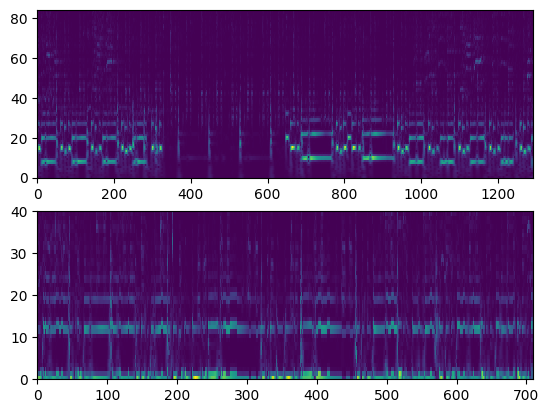

In [68]:
plt.subplot(2, 1, 1)
plt.pcolor(E_train.features['cqt'][0])
chifted_cqt = shift_cqt_by_f0(E_train.features['cqt'][0], 
                              E_train.features['f0'][0], 
                              E_train.features['voiced'][0], 
                              cqt_frequencies)
plt.subplot(2, 1, 2)
plt.pcolor(chifted_cqt)

In [70]:
Extractor.register_extractor('overtones', lambda cqt, f0, voiced: 
                             shift_cqt_by_f0(cqt, f0, voiced, cqt_frequencies))
Extractor.register_extractor('overtones_freq_mean', lambda overtones: 
                             np.mean(overtones, axis=1) if overtones.shape[1] > 0 else np.zeros(overtones.shape[0]))
Extractor.register_extractor('overtones_freq_var', lambda overtones: 
                             np.var(overtones, axis=1) if overtones.shape[1] > 0 else np.zeros(overtones.shape[0]))
# Extractor.register_sklearn_extractor('overtones_freq_mean_svd', 
#                                      ['overtones_freq_mean'], 
#                                      TruncatedSVD(n_components=n_tsvd_components, n_iter=n_svd_iter, random_state=42))
# Extractor.register_sklearn_extractor('overtones_freq_var_svd', 
#                                      ['overtones_freq_var'], 
#                                      TruncatedSVD(n_components=n_tsvd_components, n_iter=n_svd_iter, random_state=42))

In [71]:
E_train.soft_extract()
E_eval.soft_extract()

overtones:   0%|          | 0/699 [00:00<?, ?it/s]

overtones_freq_mean:   0%|          | 0/699 [00:00<?, ?it/s]

overtones_freq_var:   0%|          | 0/699 [00:00<?, ?it/s]

overtones:   0%|          | 0/300 [00:00<?, ?it/s]

overtones_freq_mean:   0%|          | 0/300 [00:00<?, ?it/s]

overtones_freq_var:   0%|          | 0/300 [00:00<?, ?it/s]

In [85]:
features = ['bpm',
    'cqt_per_freq_mean', 'cqt_per_freq_var', 
    'harmonic_per_freq_mean', 'harmonic_per_freq_var', 
    'percussive_per_freq_mean', 'percussive_per_freq_var',
    'mfcc_quef_mean', 'mfcc_quef_var', 
    'cqt_spectral_centroid_mean', 'cqt_spectral_centroid_var', 
    'cqt_chroma_mean', 'cqt_chroma_var', 
    'harmonic_chroma_freq_mean', 'harmonic_chroma_freq_var', 
    'cqt_rolloff_mean', 'cqt_rolloff_var', 
    'cqt_bandwidth_mean', 'cqt_bandwidth_var',
    'percept_freq_mean', 'percept_freq_var',
    'stft_chroma_mean', 'stft_chroma_var',
    'harmonic_mean',
    ]

model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['y'])[:,0], 
    y_eval=E_eval.get_features(['y'])[:,0],
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3218884	test: 0.3433333	best: 0.3433333 (0)	total: 85.5ms	remaining: 42.6s
50:	learn: 0.7596567	test: 0.6733333	best: 0.6800000 (40)	total: 2s	remaining: 17.6s
100:	learn: 0.8569385	test: 0.7266667	best: 0.7266667 (100)	total: 3.48s	remaining: 13.8s
150:	learn: 0.8955651	test: 0.7600000	best: 0.7666667 (146)	total: 4.99s	remaining: 11.5s
200:	learn: 0.9184549	test: 0.7666667	best: 0.7666667 (146)	total: 6.38s	remaining: 9.49s
250:	learn: 0.9399142	test: 0.7900000	best: 0.7933333 (249)	total: 7.79s	remaining: 7.72s
300:	learn: 0.9527897	test: 0.7933333	best: 0.8000000 (282)	total: 9.69s	remaining: 6.41s
350:	learn: 0.9628040	test: 0.8100000	best: 0.8100000 (347)	total: 11.2s	remaining: 4.76s
400:	learn: 0.9814020	test: 0.8033333	best: 0.8133333 (382)	total: 12.6s	remaining: 3.12s
450:	learn: 0.9842632	test: 0.8166667	best: 0.8166667 (447)	total: 14.1s	remaining: 1.53s
499:	learn: 0.9871245	test: 0.8133333	best: 0.8200000 (452)	total: 16.2s	remaining: 0us

bestTest = 0.82
bes

In [80]:
pd.DataFrame(
    data=model.feature_importances_, 
    index=E_train.get_feature_names_vector(features), 
    columns=['importance']
).sort_values(by='importance', ascending=True).head(15)

,importance
percussive_per_freq_mean_6,0.0
harmonic_per_freq_var_36,0.0
percept_freq_var_49,0.0
mfcc_quef_var_12,0.0
harmonic_per_freq_var_32,0.0
harmonic_per_freq_var_31,0.0
harmonic_per_freq_var_29,0.0
harmonic_per_freq_var_28,0.0
harmonic_per_freq_var_22,0.0
mfcc_quef_mean_1,0.0


In [39]:
features = ['stats', 'rms', 'bpm',
    'cqt_per_freq_mean_svd', 'cqt_per_freq_var_svd', 
    'harmonic_per_freq_mean_svd', 'harmonic_per_freq_var_svd', 
    'percussive_per_freq_mean_svd', 'percussive_per_freq_var_svd',
    'mfcc_quef_mean', 'mfcc_quef_var', 
    'cqt_spectral_centroid_mean', 'cqt_spectral_centroid_var', 
    'cqt_chroma_mean', 'cqt_chroma_var', 
    'harmonic_chroma_freq_mean', 'harmonic_chroma_freq_var', 
    'cqt_rolloff_mean', 'cqt_rolloff_var', 
    'cqt_bandwidth_mean', 'cqt_bandwidth_var',
    'percept_freq_mean_svd', 'percept_freq_var_svd',
    'voiced_f0_mean', 'f0_var',
    'overtones_freq_mean_svd', 'overtones_freq_var_svd']

model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['y'])[:,0], 
    y_eval=E_eval.get_features(['y'])[:,0],
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.2918455	test: 0.2833333	best: 0.2833333 (0)	total: 23.9ms	remaining: 11.9s
50:	learn: 0.7911302	test: 0.6866667	best: 0.6866667 (50)	total: 710ms	remaining: 6.25s
100:	learn: 0.8769671	test: 0.7300000	best: 0.7400000 (81)	total: 1.51s	remaining: 5.98s
150:	learn: 0.9198856	test: 0.7566667	best: 0.7566667 (150)	total: 2.32s	remaining: 5.37s
200:	learn: 0.9513591	test: 0.7900000	best: 0.7900000 (200)	total: 2.88s	remaining: 4.29s
250:	learn: 0.9656652	test: 0.7900000	best: 0.7933333 (228)	total: 3.44s	remaining: 3.41s
300:	learn: 0.9742489	test: 0.7933333	best: 0.8000000 (262)	total: 3.99s	remaining: 2.64s
350:	learn: 0.9842632	test: 0.7800000	best: 0.8000000 (262)	total: 4.53s	remaining: 1.92s
400:	learn: 0.9899857	test: 0.7966667	best: 0.8000000 (262)	total: 5.05s	remaining: 1.25s
450:	learn: 0.9942775	test: 0.7966667	best: 0.8000000 (262)	total: 5.6s	remaining: 609ms
499:	learn: 0.9942775	test: 0.8100000	best: 0.8166667 (492)	total: 6.12s	remaining: 0us

bestTest = 0.81666

ChatGPT query

Write a python function with a following signature

```
rnd = np.random.default_rng(42)
def crop_by_beats(beat, harmony_specs, percussion_specs, frames_per_beat = 4, number_of_beats=16, number_of_samples=8)
    pass
```

beats is the integer array of frames at which there was a beat
upsample beats , for two neighboring values insert frames_per_beat-1 values between them uniformly cropped to the nearest frame

Next number_of_samples times sample starting position in the upsampled beats array and take number_of_beats * frames_per_beat consequent beats. Position must be sampled aligned to number_of_beats * frames_per_beat.

harmony_specs is a list of several spectrograms with harmonic parts of melody.
for each of harmony spec calculate the mean along time axis (axis = 1) between the consequent beats of the sample including the frames at which there was a beat

percussion_specs is a list of several spectrograms with percussion parts of melody. For each of percussion spec calculate the downsampled spectrogram as with harmony specs but shift the spectrogram so that the first sample was centered at the beat. The resulting length must be the same

return list of tuples containing downsampled spectrograms

In [40]:
rnd = np.random.default_rng(42)

def crop_by_beats(
    beat,
    harmony_specs,
    percussion_specs,
    frames_per_beat=4,
    number_of_beats=8,
    number_of_samples=8
):
    """
    Upsample the array of integer beat positions and then randomly extract 
    (number_of_samples) chunks of length (number_of_beats * frames_per_beat).
    
    For each chunk, compute the downsampled spectrogram:
      - For harmonic specs: take the mean along the time axis (axis=1) 
        between consecutive upsampled-beat boundaries.
      - For percussion specs: take the mean along the time axis over intervals 
        shifted so that each is centered at the corresponding upsampled beat.
    
    Parameters
    ----------
    beat : 1D array-like of int
        Array of frame indices at which a beat occurs. Must be strictly increasing.
    harmony_specs : list of np.ndarray
        Each element is a spectrogram for a harmonic component with shape 
        (freq_bins, time_frames).
    percussion_specs : list of np.ndarray
        Each element is a spectrogram for a percussion component with shape 
        (freq_bins, time_frames).
    frames_per_beat : int
        Number of subdivisions per original beat when upsampling.
    number_of_beats : int
        How many beats (in terms of upsampled subdivisions) to include in each chunk.
    number_of_samples : int
        How many random chunks to extract.
    
    Returns
    -------
    list of tuples
        A list (of length `number_of_samples`). Each element is:
        
            (harmony_downsampled_list, percussion_downsampled_list)
        
        where `harmony_downsampled_list` and `percussion_downsampled_list` are each 
        lists of spectrograms (in the same order as `harmony_specs` and 
        `percussion_specs`). Each downsampled spectrogram has shape:
        
            (freq_bins, number_of_beats * frames_per_beat)
    """
    
    # 1) Upsample 'beat' by inserting (frames_per_beat - 1) points 
    #    uniformly between each pair of consecutive beats.
    up_beats = []
    beat = np.array(beat, dtype=int)
    for i in range(len(beat) - 1):
        start = beat[i]
        end = beat[i + 1]
        diff = end - start
        
        # Insert frames_per_beat subdivisions between start and end, 
        # snapping to the nearest integer frame.
        for k in range(frames_per_beat):
            val = start + round(k * diff / frames_per_beat)
            # Avoid duplicates if rounding yields same as last appended
            if not up_beats or val != up_beats[-1]:
                up_beats.append(val)
    
    up_beats = np.array(up_beats, dtype=int)
    
    # 2) We need (number_of_beats * frames_per_beat + 1) upsampled-beat 
    #    positions for each chunk (the +1 is because we need the right boundary).
    needed_length = number_of_beats * frames_per_beat + 1
    total_upsampled = len(up_beats)
    
    # If we cannot extract even one chunk, return empty
    max_start = total_upsampled - needed_length
    if max_start < 0:
        return []
    
    # Possible start indices must be multiples of (4 * frames_per_beat)
    # so that each chunk is "aligned".
    stride = number_of_beats * frames_per_beat
    possible_starts = np.arange(0, max_start + 1, stride)
    
    # Randomly choose 'number_of_samples' start indices from these possibilities
    chosen_starts = rnd.choice(possible_starts, size=number_of_samples, replace=True)
    
    results = []
    for start_idx in chosen_starts:
        # Boundaries for this sample
        boundary_points = up_beats[start_idx : start_idx + needed_length]
        # === 3) Downsample each harmony spec ===
        harmony_downsampled = []
        for spec in harmony_specs:
            # spec has shape (freq_bins, time_frames)
            freq_bins = spec.shape[0]
            
            # We'll get (number_of_beats * frames_per_beat) intervals
            ds_harm = np.zeros((freq_bins, number_of_beats * frames_per_beat),
                               dtype=spec.dtype)
            for j in range(number_of_beats * frames_per_beat):
                left = boundary_points[j]
                right = boundary_points[j + 1]
                # Take the average along axis=1 (time axis)
                ds_harm[:, j] = spec[:, left:right].mean(axis=1)

            harmony_downsampled.append(ds_harm)
        
        # === 4) Downsample each percussion spec with centering ===
        percussion_downsampled = []
        percussion_sampled = []
        for spec in percussion_specs:
            
            freq_bins = spec.shape[0]
            ds_perc = np.zeros((freq_bins, number_of_beats * frames_per_beat),
                               dtype=spec.dtype)

            old_right = None
            for j in range(number_of_beats * frames_per_beat):
                dist = boundary_points[j + 1] - boundary_points[j]
                right = boundary_points[j + 1] - dist // 2
                if old_right is None:
                    left = boundary_points[j] - dist // 2
                    if left < 0:
                        left = 0
                else:
                    left = old_right
                old_right = right

                # Average over the time axis in [left, right)
                chunk = spec[:, left:right]
                ds_perc[:, j] = chunk.mean(axis=1)

            percussion_downsampled.append(ds_perc)
        
        # One result entry = (list_of_downsampled_harmony_specs, list_of_downsampled_percussion_specs)
        results.append((harmony_downsampled, percussion_downsampled))
    return results

In [41]:
Extractor.register_extractor('sample', 
                             lambda beat, cqt, harmonic, mfcc, cqt_chroma, harmonic_chroma, percussive: 
                             crop_by_beats(
                                 beat=beat, 
                                 harmony_specs=[cqt, harmonic, mfcc, cqt_chroma, harmonic_chroma], 
                                 percussion_specs=[percussive]
                             ), shuffle=True, map_labels=[
                                 ('idx', 's_idx'), 
                                 ('y', 's_y'), 
                             ])
Extractor.register_extractor('s_cqt', lambda sample: sample[0][0])
Extractor.register_extractor('s_harmonic', lambda sample: sample[0][1])
Extractor.register_extractor('s_mfcc', lambda sample: sample[0][2])
Extractor.register_extractor('s_cqt_chroma', lambda sample: sample[0][3])
Extractor.register_extractor('s_harmonic_chroma', lambda sample: sample[0][4])
Extractor.register_extractor('s_percussive', lambda sample: sample[1][0])

In [42]:
del E_train.features['sample']
del E_eval.features['sample']
for f in list(E_train.features.keys()):
    if f.startswith('s_'):
        del E_train.features[f]
        del E_eval.features[f]

KeyError: 'sample'

In [ ]:
E_train.soft_extract()
E_eval.soft_extract()

In [ ]:
Extractor.register_extractor('s_percussive_beat_frames', 
                             lambda s_percussive: s_percussive.mean(axis=0))

In [ ]:
E_train.soft_extract()
E_eval.soft_extract()

In [ ]:
plt.subplot(2, 2, 1)
plt.plot(E_train.features['s_percussive_beat_frames'][0])
plt.subplot(2, 2, 2)
plt.plot(E_train.features['s_percussive_beat_frames'][1])
plt.subplot(2, 2, 3)
plt.plot(E_train.features['s_percussive_beat_frames'][2])
plt.subplot(2, 2, 4)
plt.plot(E_train.features['s_percussive_beat_frames'][3])

In [ ]:
from sklearn.cluster import KMeans

class KMeansAdapter(KMeans):
    def transform(self, *args, **kwargs):
        return self.predict(*args, **kwargs).reshape(-1, 1)
    def fit_transform(self, *args, **kwargs):
        return self.fit_predict(*args, **kwargs).reshape(-1, 1)
n_clusters=8
Extractor.register_sklearn_extractor('s_percussive_beat_frames_kmeans', ['s_percussive_beat_frames'], KMeansAdapter(n_clusters=n_clusters))

In [ ]:
E_train.train

In [ ]:
del E_train.features['s_percussive_beat_frames_kmeans']
del E_eval.features['s_percussive_beat_frames_kmeans']
E_train.soft_extract()
E_eval.soft_extract()

In [ ]:
import matplotlib.ticker as ticker
centers = Extractor._stateful_extractors['s_percussive_beat_frames_kmeans'][0].cluster_centers_
h = (len(centers) + 2) // 2
for i, c in enumerate(centers):
    ax = plt.subplot(h, 2, i + 1)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(base=4))
    plt.plot(c)
    plt.grid(axis='x', which='both')

In [ ]:
Extractor.register_sklearn_extractor('s_percussive_beat_frames_svd', ['s_percussive_beat_frames'], 
                                     TruncatedSVD(
                                         n_components=n_tsvd_components, 
                                         n_iter=n_svd_iter, 
                                         random_state=42
                                     ))

In [ ]:
E_train.soft_extract()
E_eval.soft_extract()

In [ ]:
def sum_beats(E, feature_names, idx, to_idx):
    return [np.array(list(x[1])) for x in pd.DataFrame(data=E.get_features(
        [idx] + feature_names
    ), columns=["idx"] + list(E.get_feature_names_vector(feature_names))) \
    .groupby("idx").agg("sum") \
    .loc[E.get_features([to_idx])[:,0]].iterrows()]
E_train.features['percussive_beat_frames_svd'] = sum_beats(E_train, ["s_percussive_beat_frames_svd"], "s_idx", "idx")
E_eval.features['percussive_beat_frames_svd'] = sum_beats(E_eval, ["s_percussive_beat_frames_svd"], "s_idx", "idx")

In [ ]:
plt.plot(E_train.features['percussive_beat_frames_svd'][10])

In [ ]:
def ohe(s):
    v = [0] * n_clusters
    for i in s:
        v[i] += 1
    return v

def aggregate(E, feature_names, idx, to_idx):
    return [np.array(x) for x in pd.DataFrame(data=E.get_features(
        [idx] + feature_names
    ), columns=["idx"] + feature_names) \
    .groupby("idx").agg(ohe) \
    .loc[E.get_features([to_idx])[:,0]]['s_percussive_beat_frames_kmeans']]
E_train.features['percussive_beat_frames_kmeans'] = aggregate(E_train, ["s_percussive_beat_frames_kmeans"], "s_idx", "idx")
E_eval.features['percussive_beat_frames_kmeans'] = aggregate(E_eval, ["s_percussive_beat_frames_kmeans"], "s_idx", "idx")

In [ ]:
import importlib
train_and_evaluate_catboost = importlib.reload(importlib.import_module('model')).train_and_evaluate_catboost

In [ ]:
# ChatGPT query:
#
# I have an array with feature names and I want to generate weights for the features. Some of the feature names look like <name>_<index>. 
# I want to make a function receiving a dict with prefixes and corresponding feature weights. 
# It should return the np.array of the same shape as feature_names, containing weights. 
# If the feature name starts with prefix from the dict then the weight has to be taken from the dict, otherwise it has to be 1. 
# Here is the signature:
# 
# def assign_feature_weights(feature_names: np.ndarray, weights: dict[str, int]) -> np.ndarray:
#     pass

import numpy as np

def assign_feature_weights(feature_names: np.ndarray, weights: dict[str, float]) -> np.ndarray:
    """
    Assign weights to features based on given prefixes.
    
    Parameters
    ----------
    feature_names : np.ndarray
        Array of feature names.
    weights : dict[str, float]
        Dictionary mapping a prefix (string) to a weight (float).
        
    Returns
    -------
    np.ndarray
        An array of the same shape as `feature_names` containing the assigned weights. 
        If a feature name starts with any prefix in `weights`, the corresponding weight 
        is used. Otherwise, the weight is 1.0.
    """
    result_weights = np.ones_like(feature_names, dtype=float)  # default is 1.0
    
    for i, fname in enumerate(feature_names):
        for prefix, w in weights.items():
            if fname.startswith(prefix):
                result_weights[i] = w
                break  # Stop at the first matching prefix

    return result_weights

In [ ]:
features = ['stats', 'rms', 'bpm',
    'cqt_per_freq_mean_svd', 'cqt_per_freq_var_svd', 
    'harmonic_per_freq_mean_svd', 'harmonic_per_freq_var_svd', 
    'percussive_per_freq_mean_svd', 'percussive_per_freq_var_svd',
    'mfcc_quef_mean', 'mfcc_quef_var', 
    'cqt_spectral_centroid_mean', 'cqt_spectral_centroid_var', 
    'cqt_chroma_mean', 'cqt_chroma_var', 
    'harmonic_chroma_freq_mean', 'harmonic_chroma_freq_var', 
    'cqt_rolloff_mean', 'cqt_rolloff_var', 
    'cqt_bandwidth_mean', 'cqt_bandwidth_var',
    'percept_freq_mean_svd', 'percept_freq_var_svd',
    'voiced_f0_mean', 'f0_var',
    'overtones_freq_mean_svd', 'overtones_freq_var_svd',
    ]

weights = assign_feature_weights(E_eval.get_feature_names_vector(features), 
                                 dict(percussive_beat_frames_kmeans=1))
model, acc = train_and_evaluate_catboost(
    idx_eval=E_eval.get_features(['idx'])[:,0],
    X_train=E_train.get_features(features),
    X_eval=E_eval.get_features(features),
    y_train=E_train.get_features(['y'])[:,0], 
    y_eval=E_eval.get_features(['y'])[:,0],
)

In [ ]:
imp = pd.DataFrame(
    data=model.feature_importances_, 
    index=E_train.get_feature_names_vector(features), 
    columns=['importance']
).sort_values(by='importance', ascending=False).head(15)
imp['stat_name'] = pd.Series(imp.index, index=imp.index).apply(lambda x: int(x[6:]) if x.startswith('stats_') else None)
imp['stat_name'] = imp['stat_name'].apply(lambda x: X_train.columns[int(x) + 2] if not np.isnan(x) else None)
imp